## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

sys.path.insert(0, '../src_code')

import models

# utils contains all the train and eval functions 
from utils import * 

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 10
batch_size = 128
lr = 0.001
k = 3

target_net_type = models.mlleaks_cnn
shadow_net_type = models.mlleaks_cnn

## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


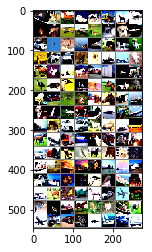

In [3]:
# define series of transforms to pre process images 
train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    

    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('../datasets/', train=True, transform=train_transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('../datasets/', train=False, transform=test_transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

In [4]:

total_size = len(cifar10_trainset)
split1 = total_size // 4
split2 = split1*2
split3 = split1*3

indices = list(range(total_size))

shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]


shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_train_sampler, num_workers=1)
shadow_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_out_sampler, num_workers=1)

#attack_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_train_sampler, num_workers=1)

#attack_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_out_sampler, num_workers=1)
target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)


# the model being attacked (architecture can be different than shadow)
target_net = target_net_type().to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)


# shadow net mimics the target network (architecture can be different than target)
shadow_net = shadow_net_type().to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)


# attack net is a binary classifier to determine membership 

attack_net = models.mlleaks_mlp(n_in=k).to(device)
attack_net.apply(models.weights_init)

#attack_loss = nn.BCEWithLogitsLoss()
attack_loss = nn.BCELoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=lr)


In [5]:
train(shadow_net, shadow_train_loader, cifar10_testloader, shadow_optim, shadow_loss, n_epochs, classes=classes)

[0/10]
Accuracy of airplane : 74.60 %
Accuracy of automobile : 29.30 %
Accuracy of bird : 44.80 %
Accuracy of cat : 47.90 %
Accuracy of deer : 6.70 %
Accuracy of dog : 28.50 %
Accuracy of frog : 11.00 %
Accuracy of horse : 43.70 %
Accuracy of ship : 35.30 %
Accuracy of truck : 1.70 %

Total accuracy = 32.35 %


[1/10]
Accuracy of airplane : 26.20 %
Accuracy of automobile : 53.90 %
Accuracy of bird : 61.20 %
Accuracy of cat : 6.20 %
Accuracy of deer : 2.60 %
Accuracy of dog : 60.60 %
Accuracy of frog : 30.40 %
Accuracy of horse : 49.30 %
Accuracy of ship : 76.40 %
Accuracy of truck : 52.70 %

Total accuracy = 41.95 %


[2/10]
Accuracy of airplane : 75.50 %
Accuracy of automobile : 51.80 %
Accuracy of bird : 29.50 %
Accuracy of cat : 57.30 %
Accuracy of deer : 26.10 %
Accuracy of dog : 39.20 %
Accuracy of frog : 66.50 %
Accuracy of horse : 33.80 %
Accuracy of ship : 17.10 %
Accuracy of truck : 45.70 %

Total accuracy = 44.25 %


[3/10]
Accuracy of airplane : 50.40 %
Accuracy of automobil

In [6]:

train_attacker(attack_net, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim, attack_loss, n_epochs=50, k=k)

[0/50][0/98] loss = 0.71, accuracy = 50.00
[0/50][1/98] loss = 0.70, accuracy = 50.00
[0/50][2/98] loss = 0.70, accuracy = 50.00
[0/50][3/98] loss = 0.70, accuracy = 50.00
[0/50][4/98] loss = 0.70, accuracy = 50.00
[0/50][5/98] loss = 0.70, accuracy = 50.00
[0/50][6/98] loss = 0.70, accuracy = 50.00
[0/50][7/98] loss = 0.70, accuracy = 50.00
[0/50][8/98] loss = 0.70, accuracy = 50.00
[0/50][9/98] loss = 0.70, accuracy = 50.00
[0/50][10/98] loss = 0.70, accuracy = 50.00
[0/50][11/98] loss = 0.70, accuracy = 50.00
[0/50][12/98] loss = 0.69, accuracy = 50.00
[0/50][13/98] loss = 0.69, accuracy = 50.00
[0/50][14/98] loss = 0.70, accuracy = 50.00
[0/50][15/98] loss = 0.69, accuracy = 50.00
[0/50][16/98] loss = 0.69, accuracy = 50.00
[0/50][17/98] loss = 0.70, accuracy = 50.00
[0/50][18/98] loss = 0.69, accuracy = 50.00
[0/50][19/98] loss = 0.69, accuracy = 50.00
[0/50][20/98] loss = 0.69, accuracy = 50.00
[0/50][21/98] loss = 0.69, accuracy = 50.00
[0/50][22/98] loss = 0.69, accuracy = 50.0

[1/50][89/98] loss = 0.69, accuracy = 49.19
[1/50][90/98] loss = 0.69, accuracy = 49.24
[1/50][91/98] loss = 0.69, accuracy = 49.29
[1/50][92/98] loss = 0.69, accuracy = 49.32
[1/50][93/98] loss = 0.69, accuracy = 49.34
[1/50][94/98] loss = 0.69, accuracy = 49.35
[1/50][95/98] loss = 0.69, accuracy = 49.37
[1/50][96/98] loss = 0.69, accuracy = 49.42
[1/50][97/98] loss = 0.69, accuracy = 49.46
[2/50][0/98] loss = 0.69, accuracy = 51.56
[2/50][1/98] loss = 0.69, accuracy = 51.95
[2/50][2/98] loss = 0.69, accuracy = 50.52
[2/50][3/98] loss = 0.69, accuracy = 50.29
[2/50][4/98] loss = 0.69, accuracy = 49.53
[2/50][5/98] loss = 0.69, accuracy = 49.15
[2/50][6/98] loss = 0.69, accuracy = 49.67
[2/50][7/98] loss = 0.69, accuracy = 49.61
[2/50][8/98] loss = 0.69, accuracy = 49.61
[2/50][9/98] loss = 0.69, accuracy = 49.73
[2/50][10/98] loss = 0.69, accuracy = 49.79
[2/50][11/98] loss = 0.69, accuracy = 49.87
[2/50][12/98] loss = 0.69, accuracy = 50.00
[2/50][13/98] loss = 0.69, accuracy = 50.0

[3/50][88/98] loss = 0.69, accuracy = 51.06
[3/50][89/98] loss = 0.69, accuracy = 51.07
[3/50][90/98] loss = 0.69, accuracy = 51.08
[3/50][91/98] loss = 0.69, accuracy = 51.08
[3/50][92/98] loss = 0.69, accuracy = 51.09
[3/50][93/98] loss = 0.69, accuracy = 51.13
[3/50][94/98] loss = 0.69, accuracy = 51.14
[3/50][95/98] loss = 0.69, accuracy = 51.16
[3/50][96/98] loss = 0.69, accuracy = 51.12
[3/50][97/98] loss = 0.69, accuracy = 51.10
[4/50][0/98] loss = 0.69, accuracy = 50.00
[4/50][1/98] loss = 0.69, accuracy = 52.15
[4/50][2/98] loss = 0.69, accuracy = 51.82
[4/50][3/98] loss = 0.69, accuracy = 52.54
[4/50][4/98] loss = 0.69, accuracy = 52.03
[4/50][5/98] loss = 0.69, accuracy = 52.21
[4/50][6/98] loss = 0.69, accuracy = 51.40
[4/50][7/98] loss = 0.69, accuracy = 51.22
[4/50][8/98] loss = 0.69, accuracy = 50.91
[4/50][9/98] loss = 0.69, accuracy = 51.17
[4/50][10/98] loss = 0.69, accuracy = 51.53
[4/50][11/98] loss = 0.69, accuracy = 51.63
[4/50][12/98] loss = 0.69, accuracy = 51.7

[5/50][79/98] loss = 0.69, accuracy = 51.65
[5/50][80/98] loss = 0.69, accuracy = 51.65
[5/50][81/98] loss = 0.69, accuracy = 51.61
[5/50][82/98] loss = 0.69, accuracy = 51.62
[5/50][83/98] loss = 0.69, accuracy = 51.64
[5/50][84/98] loss = 0.69, accuracy = 51.59
[5/50][85/98] loss = 0.69, accuracy = 51.55
[5/50][86/98] loss = 0.69, accuracy = 51.55
[5/50][87/98] loss = 0.69, accuracy = 51.53
[5/50][88/98] loss = 0.69, accuracy = 51.57
[5/50][89/98] loss = 0.69, accuracy = 51.60
[5/50][90/98] loss = 0.69, accuracy = 51.64
[5/50][91/98] loss = 0.69, accuracy = 51.61
[5/50][92/98] loss = 0.69, accuracy = 51.66
[5/50][93/98] loss = 0.69, accuracy = 51.74
[5/50][94/98] loss = 0.69, accuracy = 51.77
[5/50][95/98] loss = 0.69, accuracy = 51.75
[5/50][96/98] loss = 0.69, accuracy = 51.78
[5/50][97/98] loss = 0.69, accuracy = 51.78
[6/50][0/98] loss = 0.69, accuracy = 53.91
[6/50][1/98] loss = 0.69, accuracy = 54.88
[6/50][2/98] loss = 0.69, accuracy = 52.73
[6/50][3/98] loss = 0.69, accuracy 

[7/50][79/98] loss = 0.69, accuracy = 51.67
[7/50][80/98] loss = 0.69, accuracy = 51.70
[7/50][81/98] loss = 0.69, accuracy = 51.72
[7/50][82/98] loss = 0.70, accuracy = 51.65
[7/50][83/98] loss = 0.69, accuracy = 51.65
[7/50][84/98] loss = 0.69, accuracy = 51.62
[7/50][85/98] loss = 0.69, accuracy = 51.62
[7/50][86/98] loss = 0.69, accuracy = 51.62
[7/50][87/98] loss = 0.69, accuracy = 51.66
[7/50][88/98] loss = 0.69, accuracy = 51.69
[7/50][89/98] loss = 0.69, accuracy = 51.77
[7/50][90/98] loss = 0.69, accuracy = 51.78
[7/50][91/98] loss = 0.69, accuracy = 51.82
[7/50][92/98] loss = 0.69, accuracy = 51.85
[7/50][93/98] loss = 0.69, accuracy = 51.85
[7/50][94/98] loss = 0.69, accuracy = 51.88
[7/50][95/98] loss = 0.69, accuracy = 51.97
[7/50][96/98] loss = 0.69, accuracy = 51.98
[7/50][97/98] loss = 0.69, accuracy = 51.94
[8/50][0/98] loss = 0.69, accuracy = 55.86
[8/50][1/98] loss = 0.69, accuracy = 51.56
[8/50][2/98] loss = 0.69, accuracy = 50.52
[8/50][3/98] loss = 0.69, accuracy 

[9/50][79/98] loss = 0.69, accuracy = 52.21
[9/50][80/98] loss = 0.69, accuracy = 52.22
[9/50][81/98] loss = 0.69, accuracy = 52.16
[9/50][82/98] loss = 0.69, accuracy = 52.24
[9/50][83/98] loss = 0.70, accuracy = 52.15
[9/50][84/98] loss = 0.69, accuracy = 52.15
[9/50][85/98] loss = 0.69, accuracy = 52.17
[9/50][86/98] loss = 0.69, accuracy = 52.16
[9/50][87/98] loss = 0.69, accuracy = 52.19
[9/50][88/98] loss = 0.69, accuracy = 52.20
[9/50][89/98] loss = 0.69, accuracy = 52.23
[9/50][90/98] loss = 0.70, accuracy = 52.15
[9/50][91/98] loss = 0.69, accuracy = 52.10
[9/50][92/98] loss = 0.69, accuracy = 52.09
[9/50][93/98] loss = 0.69, accuracy = 52.12
[9/50][94/98] loss = 0.69, accuracy = 52.13
[9/50][95/98] loss = 0.69, accuracy = 52.15
[9/50][96/98] loss = 0.69, accuracy = 52.16
[9/50][97/98] loss = 0.69, accuracy = 52.19
[10/50][0/98] loss = 0.69, accuracy = 55.47
[10/50][1/98] loss = 0.69, accuracy = 56.05
[10/50][2/98] loss = 0.69, accuracy = 54.69
[10/50][3/98] loss = 0.69, accur

[11/50][70/98] loss = 0.69, accuracy = 52.24
[11/50][71/98] loss = 0.69, accuracy = 52.22
[11/50][72/98] loss = 0.70, accuracy = 52.10
[11/50][73/98] loss = 0.69, accuracy = 52.13
[11/50][74/98] loss = 0.69, accuracy = 52.10
[11/50][75/98] loss = 0.69, accuracy = 52.19
[11/50][76/98] loss = 0.69, accuracy = 52.12
[11/50][77/98] loss = 0.69, accuracy = 52.11
[11/50][78/98] loss = 0.69, accuracy = 52.14
[11/50][79/98] loss = 0.69, accuracy = 52.18
[11/50][80/98] loss = 0.69, accuracy = 52.22
[11/50][81/98] loss = 0.69, accuracy = 52.27
[11/50][82/98] loss = 0.69, accuracy = 52.25
[11/50][83/98] loss = 0.69, accuracy = 52.25
[11/50][84/98] loss = 0.69, accuracy = 52.31
[11/50][85/98] loss = 0.69, accuracy = 52.31
[11/50][86/98] loss = 0.69, accuracy = 52.31
[11/50][87/98] loss = 0.69, accuracy = 52.29
[11/50][88/98] loss = 0.69, accuracy = 52.32
[11/50][89/98] loss = 0.69, accuracy = 52.33
[11/50][90/98] loss = 0.69, accuracy = 52.31
[11/50][91/98] loss = 0.69, accuracy = 52.30
[11/50][92

[13/50][63/98] loss = 0.69, accuracy = 52.66
[13/50][64/98] loss = 0.70, accuracy = 52.58
[13/50][65/98] loss = 0.69, accuracy = 52.55
[13/50][66/98] loss = 0.69, accuracy = 52.62
[13/50][67/98] loss = 0.69, accuracy = 52.60
[13/50][68/98] loss = 0.69, accuracy = 52.56
[13/50][69/98] loss = 0.69, accuracy = 52.67
[13/50][70/98] loss = 0.69, accuracy = 52.67
[13/50][71/98] loss = 0.69, accuracy = 52.67
[13/50][72/98] loss = 0.69, accuracy = 52.61
[13/50][73/98] loss = 0.69, accuracy = 52.61
[13/50][74/98] loss = 0.70, accuracy = 52.52
[13/50][75/98] loss = 0.69, accuracy = 52.52
[13/50][76/98] loss = 0.69, accuracy = 52.53
[13/50][77/98] loss = 0.69, accuracy = 52.59
[13/50][78/98] loss = 0.69, accuracy = 52.57
[13/50][79/98] loss = 0.69, accuracy = 52.52
[13/50][80/98] loss = 0.69, accuracy = 52.51
[13/50][81/98] loss = 0.69, accuracy = 52.51
[13/50][82/98] loss = 0.69, accuracy = 52.50
[13/50][83/98] loss = 0.70, accuracy = 52.44
[13/50][84/98] loss = 0.69, accuracy = 52.43
[13/50][85

[15/50][54/98] loss = 0.69, accuracy = 51.57
[15/50][55/98] loss = 0.69, accuracy = 51.59
[15/50][56/98] loss = 0.69, accuracy = 51.67
[15/50][57/98] loss = 0.69, accuracy = 51.70
[15/50][58/98] loss = 0.69, accuracy = 51.73
[15/50][59/98] loss = 0.69, accuracy = 51.76
[15/50][60/98] loss = 0.69, accuracy = 51.78
[15/50][61/98] loss = 0.69, accuracy = 51.77
[15/50][62/98] loss = 0.69, accuracy = 51.76
[15/50][63/98] loss = 0.69, accuracy = 51.87
[15/50][64/98] loss = 0.69, accuracy = 51.83
[15/50][65/98] loss = 0.70, accuracy = 51.76
[15/50][66/98] loss = 0.69, accuracy = 51.82
[15/50][67/98] loss = 0.69, accuracy = 51.86
[15/50][68/98] loss = 0.69, accuracy = 51.87
[15/50][69/98] loss = 0.69, accuracy = 51.87
[15/50][70/98] loss = 0.69, accuracy = 51.88
[15/50][71/98] loss = 0.69, accuracy = 51.89
[15/50][72/98] loss = 0.69, accuracy = 51.88
[15/50][73/98] loss = 0.69, accuracy = 51.87
[15/50][74/98] loss = 0.69, accuracy = 51.92
[15/50][75/98] loss = 0.69, accuracy = 51.89
[15/50][76

[17/50][41/98] loss = 0.69, accuracy = 52.67
[17/50][42/98] loss = 0.69, accuracy = 52.64
[17/50][43/98] loss = 0.70, accuracy = 52.57
[17/50][44/98] loss = 0.70, accuracy = 52.45
[17/50][45/98] loss = 0.69, accuracy = 52.45
[17/50][46/98] loss = 0.69, accuracy = 52.37
[17/50][47/98] loss = 0.69, accuracy = 52.26
[17/50][48/98] loss = 0.69, accuracy = 52.26
[17/50][49/98] loss = 0.69, accuracy = 52.24
[17/50][50/98] loss = 0.69, accuracy = 52.19
[17/50][51/98] loss = 0.69, accuracy = 52.22
[17/50][52/98] loss = 0.69, accuracy = 52.19
[17/50][53/98] loss = 0.69, accuracy = 52.16
[17/50][54/98] loss = 0.69, accuracy = 52.27
[17/50][55/98] loss = 0.69, accuracy = 52.27
[17/50][56/98] loss = 0.69, accuracy = 52.27
[17/50][57/98] loss = 0.69, accuracy = 52.32
[17/50][58/98] loss = 0.69, accuracy = 52.34
[17/50][59/98] loss = 0.69, accuracy = 52.33
[17/50][60/98] loss = 0.69, accuracy = 52.38
[17/50][61/98] loss = 0.69, accuracy = 52.41
[17/50][62/98] loss = 0.69, accuracy = 52.37
[17/50][63

[19/50][30/98] loss = 0.69, accuracy = 52.41
[19/50][31/98] loss = 0.69, accuracy = 52.38
[19/50][32/98] loss = 0.69, accuracy = 52.30
[19/50][33/98] loss = 0.69, accuracy = 52.33
[19/50][34/98] loss = 0.69, accuracy = 52.38
[19/50][35/98] loss = 0.69, accuracy = 52.56
[19/50][36/98] loss = 0.69, accuracy = 52.46
[19/50][37/98] loss = 0.69, accuracy = 52.50
[19/50][38/98] loss = 0.69, accuracy = 52.63
[19/50][39/98] loss = 0.69, accuracy = 52.59
[19/50][40/98] loss = 0.69, accuracy = 52.63
[19/50][41/98] loss = 0.70, accuracy = 52.51
[19/50][42/98] loss = 0.69, accuracy = 52.48
[19/50][43/98] loss = 0.69, accuracy = 52.41
[19/50][44/98] loss = 0.70, accuracy = 52.27
[19/50][45/98] loss = 0.69, accuracy = 52.27
[19/50][46/98] loss = 0.69, accuracy = 52.36
[19/50][47/98] loss = 0.69, accuracy = 52.46
[19/50][48/98] loss = 0.69, accuracy = 52.48
[19/50][49/98] loss = 0.69, accuracy = 52.45
[19/50][50/98] loss = 0.69, accuracy = 52.50
[19/50][51/98] loss = 0.69, accuracy = 52.54
[19/50][52

[21/50][18/98] loss = 0.69, accuracy = 51.73
[21/50][19/98] loss = 0.69, accuracy = 51.86
[21/50][20/98] loss = 0.69, accuracy = 51.77
[21/50][21/98] loss = 0.70, accuracy = 51.53
[21/50][22/98] loss = 0.69, accuracy = 51.61
[21/50][23/98] loss = 0.69, accuracy = 51.58
[21/50][24/98] loss = 0.69, accuracy = 51.55
[21/50][25/98] loss = 0.70, accuracy = 51.37
[21/50][26/98] loss = 0.69, accuracy = 51.56
[21/50][27/98] loss = 0.69, accuracy = 51.58
[21/50][28/98] loss = 0.69, accuracy = 51.47
[21/50][29/98] loss = 0.69, accuracy = 51.46
[21/50][30/98] loss = 0.70, accuracy = 51.26
[21/50][31/98] loss = 0.69, accuracy = 51.38
[21/50][32/98] loss = 0.69, accuracy = 51.46
[21/50][33/98] loss = 0.69, accuracy = 51.40
[21/50][34/98] loss = 0.69, accuracy = 51.46
[21/50][35/98] loss = 0.69, accuracy = 51.64
[21/50][36/98] loss = 0.69, accuracy = 51.69
[21/50][37/98] loss = 0.69, accuracy = 51.82
[21/50][38/98] loss = 0.69, accuracy = 51.88
[21/50][39/98] loss = 0.69, accuracy = 51.88
[21/50][40

[23/50][9/98] loss = 0.69, accuracy = 54.30
[23/50][10/98] loss = 0.69, accuracy = 54.01
[23/50][11/98] loss = 0.69, accuracy = 54.04
[23/50][12/98] loss = 0.69, accuracy = 53.91
[23/50][13/98] loss = 0.69, accuracy = 53.77
[23/50][14/98] loss = 0.69, accuracy = 53.88
[23/50][15/98] loss = 0.69, accuracy = 53.86
[23/50][16/98] loss = 0.69, accuracy = 53.70
[23/50][17/98] loss = 0.70, accuracy = 53.34
[23/50][18/98] loss = 0.69, accuracy = 53.10
[23/50][19/98] loss = 0.69, accuracy = 53.12
[23/50][20/98] loss = 0.69, accuracy = 53.22
[23/50][21/98] loss = 0.69, accuracy = 53.05
[23/50][22/98] loss = 0.69, accuracy = 52.99
[23/50][23/98] loss = 0.69, accuracy = 52.88
[23/50][24/98] loss = 0.69, accuracy = 52.81
[23/50][25/98] loss = 0.69, accuracy = 52.87
[23/50][26/98] loss = 0.69, accuracy = 52.85
[23/50][27/98] loss = 0.70, accuracy = 52.66
[23/50][28/98] loss = 0.69, accuracy = 52.61
[23/50][29/98] loss = 0.69, accuracy = 52.50
[23/50][30/98] loss = 0.69, accuracy = 52.56
[23/50][31/

[24/50][95/98] loss = 0.69, accuracy = 52.48
[24/50][96/98] loss = 0.69, accuracy = 52.49
[24/50][97/98] loss = 0.69, accuracy = 52.51
[25/50][0/98] loss = 0.69, accuracy = 53.91
[25/50][1/98] loss = 0.69, accuracy = 52.73
[25/50][2/98] loss = 0.69, accuracy = 52.99
[25/50][3/98] loss = 0.69, accuracy = 53.03
[25/50][4/98] loss = 0.69, accuracy = 52.97
[25/50][5/98] loss = 0.69, accuracy = 52.60
[25/50][6/98] loss = 0.69, accuracy = 53.35
[25/50][7/98] loss = 0.69, accuracy = 53.61
[25/50][8/98] loss = 0.69, accuracy = 53.65
[25/50][9/98] loss = 0.69, accuracy = 53.48
[25/50][10/98] loss = 0.70, accuracy = 52.88
[25/50][11/98] loss = 0.69, accuracy = 52.83
[25/50][12/98] loss = 0.69, accuracy = 52.85
[25/50][13/98] loss = 0.69, accuracy = 52.71
[25/50][14/98] loss = 0.69, accuracy = 53.36
[25/50][15/98] loss = 0.69, accuracy = 53.42
[25/50][16/98] loss = 0.69, accuracy = 53.31
[25/50][17/98] loss = 0.70, accuracy = 53.06
[25/50][18/98] loss = 0.70, accuracy = 52.69
[25/50][19/98] loss 

[26/50][84/98] loss = 0.69, accuracy = 52.27
[26/50][85/98] loss = 0.69, accuracy = 52.30
[26/50][86/98] loss = 0.69, accuracy = 52.29
[26/50][87/98] loss = 0.69, accuracy = 52.26
[26/50][88/98] loss = 0.69, accuracy = 52.28
[26/50][89/98] loss = 0.69, accuracy = 52.34
[26/50][90/98] loss = 0.69, accuracy = 52.36
[26/50][91/98] loss = 0.69, accuracy = 52.35
[26/50][92/98] loss = 0.70, accuracy = 52.33
[26/50][93/98] loss = 0.69, accuracy = 52.32
[26/50][94/98] loss = 0.69, accuracy = 52.34
[26/50][95/98] loss = 0.69, accuracy = 52.29
[26/50][96/98] loss = 0.69, accuracy = 52.28
[26/50][97/98] loss = 0.69, accuracy = 52.30
[27/50][0/98] loss = 0.70, accuracy = 48.83
[27/50][1/98] loss = 0.69, accuracy = 50.39
[27/50][2/98] loss = 0.69, accuracy = 50.13
[27/50][3/98] loss = 0.69, accuracy = 50.10
[27/50][4/98] loss = 0.69, accuracy = 50.39
[27/50][5/98] loss = 0.69, accuracy = 51.24
[27/50][6/98] loss = 0.69, accuracy = 51.79
[27/50][7/98] loss = 0.69, accuracy = 51.56
[27/50][8/98] loss

[28/50][73/98] loss = 0.69, accuracy = 52.37
[28/50][74/98] loss = 0.69, accuracy = 52.36
[28/50][75/98] loss = 0.69, accuracy = 52.35
[28/50][76/98] loss = 0.70, accuracy = 52.35
[28/50][77/98] loss = 0.69, accuracy = 52.37
[28/50][78/98] loss = 0.69, accuracy = 52.37
[28/50][79/98] loss = 0.69, accuracy = 52.40
[28/50][80/98] loss = 0.69, accuracy = 52.50
[28/50][81/98] loss = 0.69, accuracy = 52.48
[28/50][82/98] loss = 0.69, accuracy = 52.48
[28/50][83/98] loss = 0.69, accuracy = 52.53
[28/50][84/98] loss = 0.69, accuracy = 52.55
[28/50][85/98] loss = 0.69, accuracy = 52.58
[28/50][86/98] loss = 0.69, accuracy = 52.59
[28/50][87/98] loss = 0.69, accuracy = 52.63
[28/50][88/98] loss = 0.69, accuracy = 52.62
[28/50][89/98] loss = 0.69, accuracy = 52.59
[28/50][90/98] loss = 0.69, accuracy = 52.59
[28/50][91/98] loss = 0.69, accuracy = 52.64
[28/50][92/98] loss = 0.69, accuracy = 52.64
[28/50][93/98] loss = 0.69, accuracy = 52.66
[28/50][94/98] loss = 0.70, accuracy = 52.60
[28/50][95

[30/50][68/98] loss = 0.69, accuracy = 52.17
[30/50][69/98] loss = 0.69, accuracy = 52.23
[30/50][70/98] loss = 0.69, accuracy = 52.27
[30/50][71/98] loss = 0.69, accuracy = 52.28
[30/50][72/98] loss = 0.69, accuracy = 52.32
[30/50][73/98] loss = 0.69, accuracy = 52.28
[30/50][74/98] loss = 0.69, accuracy = 52.28
[30/50][75/98] loss = 0.69, accuracy = 52.28
[30/50][76/98] loss = 0.69, accuracy = 52.28
[30/50][77/98] loss = 0.69, accuracy = 52.29
[30/50][78/98] loss = 0.69, accuracy = 52.37
[30/50][79/98] loss = 0.70, accuracy = 52.34
[30/50][80/98] loss = 0.69, accuracy = 52.37
[30/50][81/98] loss = 0.69, accuracy = 52.35
[30/50][82/98] loss = 0.69, accuracy = 52.44
[30/50][83/98] loss = 0.69, accuracy = 52.49
[30/50][84/98] loss = 0.69, accuracy = 52.50
[30/50][85/98] loss = 0.69, accuracy = 52.54
[30/50][86/98] loss = 0.69, accuracy = 52.51
[30/50][87/98] loss = 0.70, accuracy = 52.49
[30/50][88/98] loss = 0.69, accuracy = 52.48
[30/50][89/98] loss = 0.69, accuracy = 52.47
[30/50][90

[32/50][59/98] loss = 0.69, accuracy = 52.51
[32/50][60/98] loss = 0.70, accuracy = 52.41
[32/50][61/98] loss = 0.70, accuracy = 52.33
[32/50][62/98] loss = 0.69, accuracy = 52.32
[32/50][63/98] loss = 0.69, accuracy = 52.29
[32/50][64/98] loss = 0.69, accuracy = 52.35
[32/50][65/98] loss = 0.69, accuracy = 52.33
[32/50][66/98] loss = 0.69, accuracy = 52.32
[32/50][67/98] loss = 0.69, accuracy = 52.26
[32/50][68/98] loss = 0.69, accuracy = 52.23
[32/50][69/98] loss = 0.69, accuracy = 52.17
[32/50][70/98] loss = 0.69, accuracy = 52.15
[32/50][71/98] loss = 0.69, accuracy = 52.15
[32/50][72/98] loss = 0.69, accuracy = 52.20
[32/50][73/98] loss = 0.69, accuracy = 52.17
[32/50][74/98] loss = 0.70, accuracy = 52.13
[32/50][75/98] loss = 0.68, accuracy = 52.22
[32/50][76/98] loss = 0.69, accuracy = 52.25
[32/50][77/98] loss = 0.69, accuracy = 52.21
[32/50][78/98] loss = 0.69, accuracy = 52.27
[32/50][79/98] loss = 0.69, accuracy = 52.26
[32/50][80/98] loss = 0.69, accuracy = 52.26
[32/50][81

[34/50][54/98] loss = 0.69, accuracy = 52.18
[34/50][55/98] loss = 0.69, accuracy = 52.16
[34/50][56/98] loss = 0.69, accuracy = 52.25
[34/50][57/98] loss = 0.69, accuracy = 52.20
[34/50][58/98] loss = 0.70, accuracy = 52.06
[34/50][59/98] loss = 0.69, accuracy = 52.06
[34/50][60/98] loss = 0.69, accuracy = 52.11
[34/50][61/98] loss = 0.69, accuracy = 52.15
[34/50][62/98] loss = 0.70, accuracy = 52.07
[34/50][63/98] loss = 0.69, accuracy = 52.10
[34/50][64/98] loss = 0.69, accuracy = 52.12
[34/50][65/98] loss = 0.69, accuracy = 52.11
[34/50][66/98] loss = 0.69, accuracy = 52.10
[34/50][67/98] loss = 0.69, accuracy = 52.17
[34/50][68/98] loss = 0.69, accuracy = 52.17
[34/50][69/98] loss = 0.69, accuracy = 52.25
[34/50][70/98] loss = 0.69, accuracy = 52.22
[34/50][71/98] loss = 0.69, accuracy = 52.28
[34/50][72/98] loss = 0.69, accuracy = 52.29
[34/50][73/98] loss = 0.69, accuracy = 52.31
[34/50][74/98] loss = 0.69, accuracy = 52.31
[34/50][75/98] loss = 0.69, accuracy = 52.33
[34/50][76

[36/50][44/98] loss = 0.69, accuracy = 51.65
[36/50][45/98] loss = 0.69, accuracy = 51.62
[36/50][46/98] loss = 0.69, accuracy = 51.70
[36/50][47/98] loss = 0.69, accuracy = 51.68
[36/50][48/98] loss = 0.69, accuracy = 51.65
[36/50][49/98] loss = 0.69, accuracy = 51.68
[36/50][50/98] loss = 0.69, accuracy = 51.65
[36/50][51/98] loss = 0.69, accuracy = 51.77
[36/50][52/98] loss = 0.69, accuracy = 51.75
[36/50][53/98] loss = 0.69, accuracy = 51.81
[36/50][54/98] loss = 0.69, accuracy = 51.77
[36/50][55/98] loss = 0.69, accuracy = 51.74
[36/50][56/98] loss = 0.69, accuracy = 51.84
[36/50][57/98] loss = 0.69, accuracy = 51.82
[36/50][58/98] loss = 0.70, accuracy = 51.73
[36/50][59/98] loss = 0.69, accuracy = 51.74
[36/50][60/98] loss = 0.69, accuracy = 51.72
[36/50][61/98] loss = 0.69, accuracy = 51.87
[36/50][62/98] loss = 0.69, accuracy = 51.92
[36/50][63/98] loss = 0.69, accuracy = 51.90
[36/50][64/98] loss = 0.69, accuracy = 51.90
[36/50][65/98] loss = 0.69, accuracy = 52.02
[36/50][66

[38/50][38/98] loss = 0.70, accuracy = 52.60
[38/50][39/98] loss = 0.69, accuracy = 52.64
[38/50][40/98] loss = 0.69, accuracy = 52.57
[38/50][41/98] loss = 0.69, accuracy = 52.53
[38/50][42/98] loss = 0.70, accuracy = 52.43
[38/50][43/98] loss = 0.69, accuracy = 52.45
[38/50][44/98] loss = 0.68, accuracy = 52.57
[38/50][45/98] loss = 0.69, accuracy = 52.59
[38/50][46/98] loss = 0.69, accuracy = 52.61
[38/50][47/98] loss = 0.69, accuracy = 52.63
[38/50][48/98] loss = 0.69, accuracy = 52.61
[38/50][49/98] loss = 0.70, accuracy = 52.55
[38/50][50/98] loss = 0.69, accuracy = 52.54
[38/50][51/98] loss = 0.69, accuracy = 52.52
[38/50][52/98] loss = 0.69, accuracy = 52.66
[38/50][53/98] loss = 0.69, accuracy = 52.55
[38/50][54/98] loss = 0.69, accuracy = 52.53
[38/50][55/98] loss = 0.70, accuracy = 52.50
[38/50][56/98] loss = 0.69, accuracy = 52.52
[38/50][57/98] loss = 0.69, accuracy = 52.49
[38/50][58/98] loss = 0.70, accuracy = 52.47
[38/50][59/98] loss = 0.69, accuracy = 52.45
[38/50][60

[40/50][28/98] loss = 0.69, accuracy = 51.93
[40/50][29/98] loss = 0.68, accuracy = 52.15
[40/50][30/98] loss = 0.69, accuracy = 52.26
[40/50][31/98] loss = 0.69, accuracy = 52.42
[40/50][32/98] loss = 0.69, accuracy = 52.38
[40/50][33/98] loss = 0.70, accuracy = 52.30
[40/50][34/98] loss = 0.70, accuracy = 52.15
[40/50][35/98] loss = 0.69, accuracy = 52.04
[40/50][36/98] loss = 0.69, accuracy = 51.98
[40/50][37/98] loss = 0.69, accuracy = 52.10
[40/50][38/98] loss = 0.69, accuracy = 52.09
[40/50][39/98] loss = 0.69, accuracy = 52.02
[40/50][40/98] loss = 0.69, accuracy = 52.04
[40/50][41/98] loss = 0.69, accuracy = 52.03
[40/50][42/98] loss = 0.69, accuracy = 51.99
[40/50][43/98] loss = 0.69, accuracy = 51.91
[40/50][44/98] loss = 0.69, accuracy = 52.00
[40/50][45/98] loss = 0.69, accuracy = 52.07
[40/50][46/98] loss = 0.69, accuracy = 52.04
[40/50][47/98] loss = 0.69, accuracy = 52.03
[40/50][48/98] loss = 0.69, accuracy = 52.08
[40/50][49/98] loss = 0.69, accuracy = 52.12
[40/50][50

[42/50][19/98] loss = 0.69, accuracy = 52.38
[42/50][20/98] loss = 0.69, accuracy = 52.42
[42/50][21/98] loss = 0.69, accuracy = 52.38
[42/50][22/98] loss = 0.69, accuracy = 52.65
[42/50][23/98] loss = 0.69, accuracy = 52.51
[42/50][24/98] loss = 0.69, accuracy = 52.70
[42/50][25/98] loss = 0.69, accuracy = 52.60
[42/50][26/98] loss = 0.70, accuracy = 52.47
[42/50][27/98] loss = 0.70, accuracy = 52.25
[42/50][28/98] loss = 0.70, accuracy = 52.09
[42/50][29/98] loss = 0.69, accuracy = 52.07
[42/50][30/98] loss = 0.69, accuracy = 51.97
[42/50][31/98] loss = 0.69, accuracy = 52.01
[42/50][32/98] loss = 0.69, accuracy = 52.00
[42/50][33/98] loss = 0.69, accuracy = 52.11
[42/50][34/98] loss = 0.69, accuracy = 52.13
[42/50][35/98] loss = 0.69, accuracy = 52.11
[42/50][36/98] loss = 0.69, accuracy = 52.05
[42/50][37/98] loss = 0.69, accuracy = 52.13
[42/50][38/98] loss = 0.69, accuracy = 52.01
[42/50][39/98] loss = 0.69, accuracy = 52.00
[42/50][40/98] loss = 0.69, accuracy = 52.04
[42/50][41

[44/50][9/98] loss = 0.69, accuracy = 51.72
[44/50][10/98] loss = 0.70, accuracy = 51.28
[44/50][11/98] loss = 0.70, accuracy = 51.01
[44/50][12/98] loss = 0.69, accuracy = 51.23
[44/50][13/98] loss = 0.69, accuracy = 51.48
[44/50][14/98] loss = 0.69, accuracy = 51.48
[44/50][15/98] loss = 0.69, accuracy = 51.83
[44/50][16/98] loss = 0.69, accuracy = 51.72
[44/50][17/98] loss = 0.69, accuracy = 51.93
[44/50][18/98] loss = 0.69, accuracy = 51.97
[44/50][19/98] loss = 0.69, accuracy = 51.97
[44/50][20/98] loss = 0.69, accuracy = 51.93
[44/50][21/98] loss = 0.69, accuracy = 52.02
[44/50][22/98] loss = 0.69, accuracy = 51.94
[44/50][23/98] loss = 0.69, accuracy = 52.05
[44/50][24/98] loss = 0.69, accuracy = 52.23
[44/50][25/98] loss = 0.69, accuracy = 52.31
[44/50][26/98] loss = 0.69, accuracy = 52.39
[44/50][27/98] loss = 0.69, accuracy = 52.36
[44/50][28/98] loss = 0.69, accuracy = 52.41
[44/50][29/98] loss = 0.69, accuracy = 52.41
[44/50][30/98] loss = 0.69, accuracy = 52.39
[44/50][31/

[46/50][0/98] loss = 0.69, accuracy = 50.39
[46/50][1/98] loss = 0.69, accuracy = 51.95
[46/50][2/98] loss = 0.69, accuracy = 52.34
[46/50][3/98] loss = 0.69, accuracy = 52.93
[46/50][4/98] loss = 0.69, accuracy = 52.97
[46/50][5/98] loss = 0.69, accuracy = 53.58
[46/50][6/98] loss = 0.69, accuracy = 54.19
[46/50][7/98] loss = 0.69, accuracy = 53.71
[46/50][8/98] loss = 0.69, accuracy = 53.95
[46/50][9/98] loss = 0.69, accuracy = 54.30
[46/50][10/98] loss = 0.69, accuracy = 54.15
[46/50][11/98] loss = 0.69, accuracy = 54.30
[46/50][12/98] loss = 0.69, accuracy = 54.39
[46/50][13/98] loss = 0.68, accuracy = 54.74
[46/50][14/98] loss = 0.69, accuracy = 54.43
[46/50][15/98] loss = 0.69, accuracy = 54.49
[46/50][16/98] loss = 0.70, accuracy = 54.00
[46/50][17/98] loss = 0.69, accuracy = 53.93
[46/50][18/98] loss = 0.69, accuracy = 54.03
[46/50][19/98] loss = 0.69, accuracy = 53.98
[46/50][20/98] loss = 0.69, accuracy = 53.98
[46/50][21/98] loss = 0.70, accuracy = 53.82
[46/50][22/98] loss 

[47/50][90/98] loss = 0.69, accuracy = 52.43
[47/50][91/98] loss = 0.69, accuracy = 52.45
[47/50][92/98] loss = 0.69, accuracy = 52.42
[47/50][93/98] loss = 0.69, accuracy = 52.44
[47/50][94/98] loss = 0.69, accuracy = 52.46
[47/50][95/98] loss = 0.68, accuracy = 52.53
[47/50][96/98] loss = 0.70, accuracy = 52.50
[47/50][97/98] loss = 0.69, accuracy = 52.50
[48/50][0/98] loss = 0.69, accuracy = 57.03
[48/50][1/98] loss = 0.69, accuracy = 56.25
[48/50][2/98] loss = 0.69, accuracy = 54.17
[48/50][3/98] loss = 0.69, accuracy = 54.30
[48/50][4/98] loss = 0.68, accuracy = 55.78
[48/50][5/98] loss = 0.69, accuracy = 55.53
[48/50][6/98] loss = 0.69, accuracy = 56.08
[48/50][7/98] loss = 0.70, accuracy = 55.37
[48/50][8/98] loss = 0.69, accuracy = 54.90
[48/50][9/98] loss = 0.69, accuracy = 54.73
[48/50][10/98] loss = 0.68, accuracy = 55.08
[48/50][11/98] loss = 0.69, accuracy = 55.05
[48/50][12/98] loss = 0.69, accuracy = 54.90
[48/50][13/98] loss = 0.69, accuracy = 54.91
[48/50][14/98] loss 

[49/50][77/98] loss = 0.68, accuracy = 52.49
[49/50][78/98] loss = 0.69, accuracy = 52.46
[49/50][79/98] loss = 0.69, accuracy = 52.48
[49/50][80/98] loss = 0.68, accuracy = 52.58
[49/50][81/98] loss = 0.68, accuracy = 52.65
[49/50][82/98] loss = 0.69, accuracy = 52.66
[49/50][83/98] loss = 0.70, accuracy = 52.63
[49/50][84/98] loss = 0.69, accuracy = 52.64
[49/50][85/98] loss = 0.69, accuracy = 52.63
[49/50][86/98] loss = 0.69, accuracy = 52.60
[49/50][87/98] loss = 0.69, accuracy = 52.63
[49/50][88/98] loss = 0.69, accuracy = 52.63
[49/50][89/98] loss = 0.69, accuracy = 52.66
[49/50][90/98] loss = 0.70, accuracy = 52.58
[49/50][91/98] loss = 0.69, accuracy = 52.59
[49/50][92/98] loss = 0.69, accuracy = 52.58
[49/50][93/98] loss = 0.69, accuracy = 52.58
[49/50][94/98] loss = 0.69, accuracy = 52.59
[49/50][95/98] loss = 0.69, accuracy = 52.57
[49/50][96/98] loss = 0.69, accuracy = 52.57
[49/50][97/98] loss = 0.70, accuracy = 52.55


In [7]:
train(target_net, target_train_loader, cifar10_testloader, target_optim, target_loss, n_epochs, classes=classes)

[0/10]
Accuracy of airplane : 4.90 %
Accuracy of automobile : 60.90 %
Accuracy of bird : 14.70 %
Accuracy of cat : 21.10 %
Accuracy of deer : 28.60 %
Accuracy of dog : 3.00 %
Accuracy of frog : 57.40 %
Accuracy of horse : 57.40 %
Accuracy of ship : 64.00 %
Accuracy of truck : 46.20 %

Total accuracy = 35.82 %


[1/10]
Accuracy of airplane : 11.50 %
Accuracy of automobile : 26.80 %
Accuracy of bird : 28.50 %
Accuracy of cat : 31.10 %
Accuracy of deer : 48.30 %
Accuracy of dog : 7.50 %
Accuracy of frog : 16.40 %
Accuracy of horse : 79.30 %
Accuracy of ship : 80.00 %
Accuracy of truck : 29.10 %

Total accuracy = 35.85 %


[2/10]
Accuracy of airplane : 41.50 %
Accuracy of automobile : 28.20 %
Accuracy of bird : 58.10 %
Accuracy of cat : 53.40 %
Accuracy of deer : 8.00 %
Accuracy of dog : 22.50 %
Accuracy of frog : 45.90 %
Accuracy of horse : 66.30 %
Accuracy of ship : 74.40 %
Accuracy of truck : 47.50 %

Total accuracy = 44.58 %


[3/10]
Accuracy of airplane : 78.30 %
Accuracy of automobil

In [8]:
eval_attack_net(attack_net, target_net, target_train_loader, target_out_loader, k)

accuracy = 52.22, precision = 0.52, recall = 0.57
